### Домашняя работа № 4, Кривоногов Н.В.

In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

#### скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention:

In [2]:
df = pd.read_csv('data.csv')

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [4]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.describe(include=np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [6]:
cat_features = [col for col in df.columns if df[col].dtype == 'object']

for c in cat_features:
    print('----')
    print(df[c].value_counts())

----
Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
----
Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
----
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64


#### там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие:

In [7]:
df = df.rename(columns= {'conversion': 'target', 'offer': 'treatment'})

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [8]:
df['treatment'] = df['treatment'].map({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [9]:
cat_features = [col for col in df.columns if df[col].dtype == 'object']

cat_features

['zip_code', 'channel']

In [10]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [11]:
df['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [12]:
df.groupby('treatment')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


#### сделать разбиение набора данных не тренировочную и тестовую выборки:

In [13]:
X = df.drop(['treatment', 'target'], axis=1)
y = df['target']
treat = df['treatment'][:44800].copy()

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями:

In [15]:
#! pip install scikit-uplift catboost

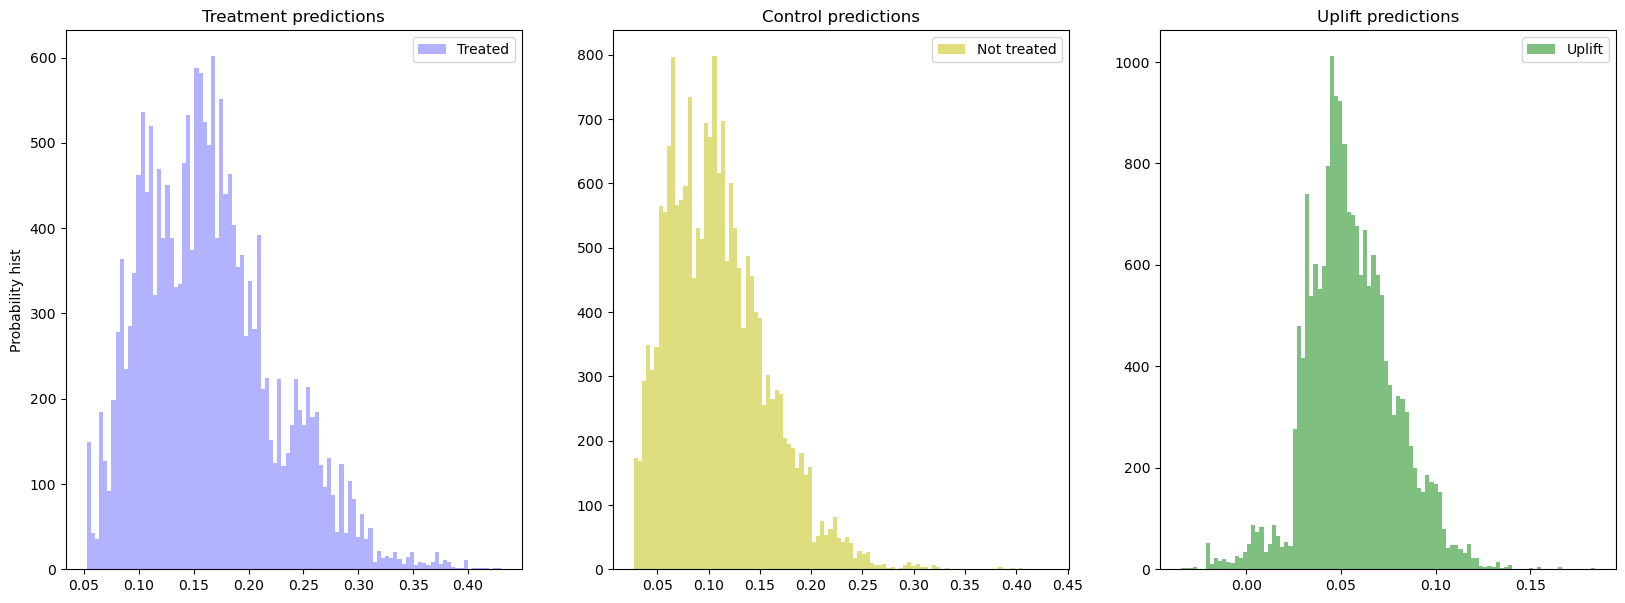

In [16]:
# одна модель с признаком коммуникации (S learner):

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat[:19200], strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat[:19200], strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [17]:
# модель с трансформацией таргета (трансформация классов): 

from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat[:19200], strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat[:19200], strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

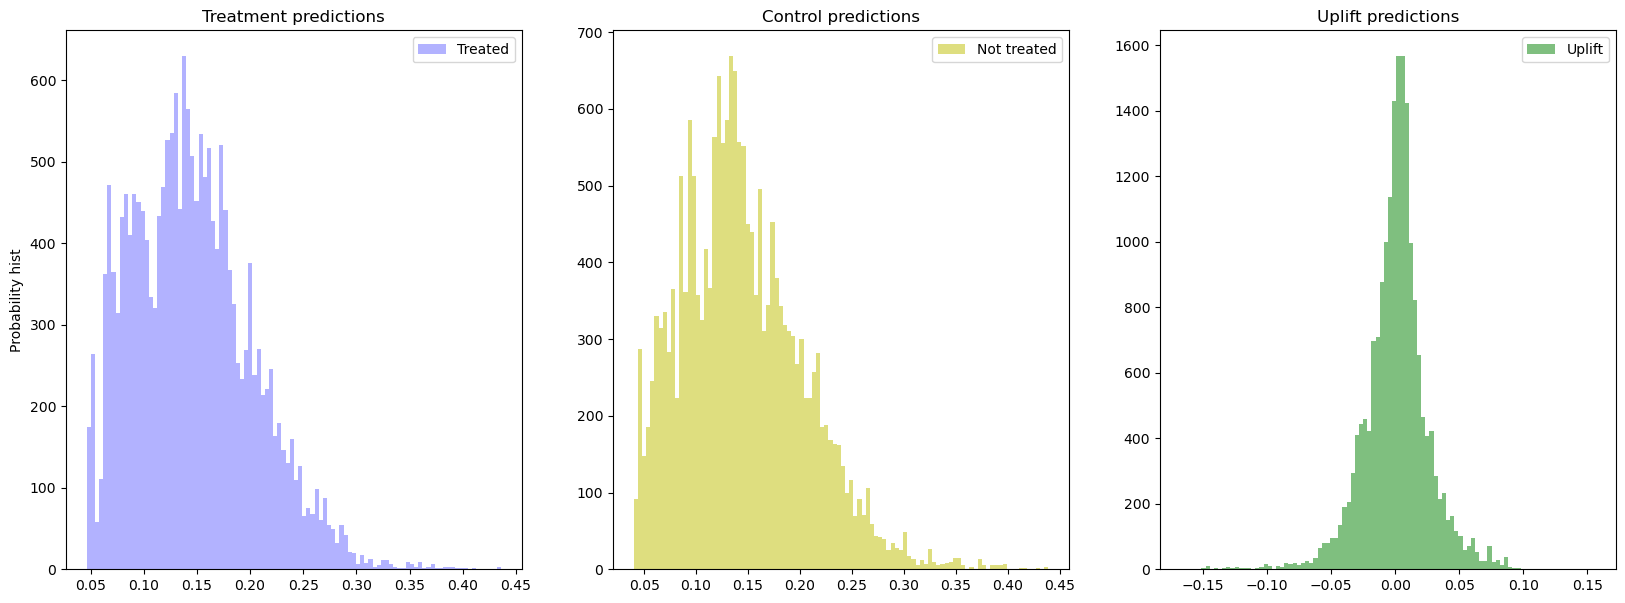

In [18]:
# вариант с двумя независимыми моделями:

from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat[:19200], strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat[:19200], strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

#### в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей:

In [19]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,-0.001615,-0.003575
1,ClassTransformation,0.015497,0.010474
2,TwoModels,0.053677,0.018156


Видно, что у варианта с двумя независимыми моделями лучшие показатели. 

#### построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево:

In [20]:
X_train_tree = pd.concat([X_train.drop('zip_code', axis=1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], axis=1)

In [21]:
X_train_tree = pd.concat([X_train_tree.drop('channel', axis=1), 
                          pd.get_dummies(X_train_tree['channel'], prefix='channel')], axis=1)

In [22]:
features = [col for col in X_train_tree]

In [23]:
#! pip install causalml

In [24]:
#! pip install duecredit

In [25]:
#! pip install graphviz

Wall time: 15.8 s


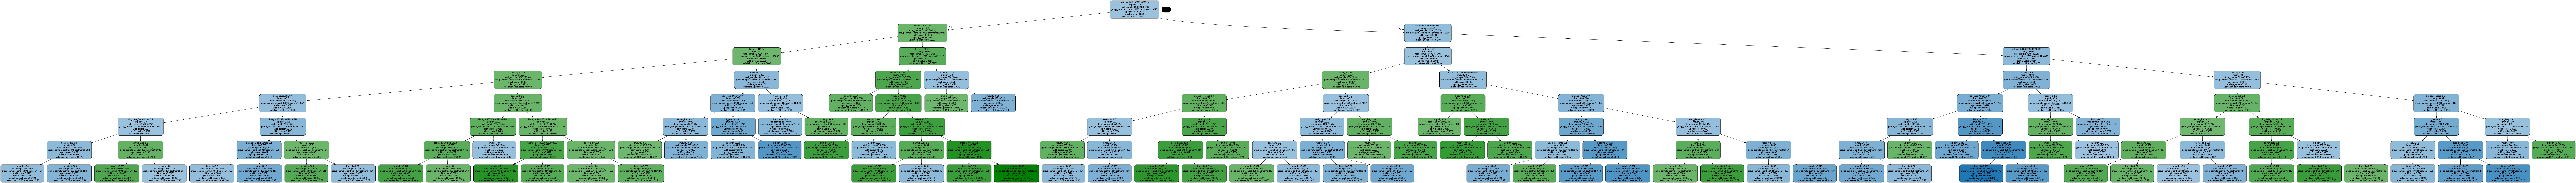

In [26]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Как раз в узлах дерева можно увидеть персональное значение uplift и сделать вывод о том, кому стоит звонить ("убеждаемые"), а кому ни в коем случае ("спящие собаки"). 